In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

In [2]:
data = pd.read_csv('data_with_sentiment_v2.csv')
import pandas as pd
df = data.reindex(pd.date_range('2020-01-02', '2022-01-31', freq ='D'))
df['Date'] = df.index
df.reset_index(drop=True, inplace=True)
df1 = df['Date'].to_frame()
df1.to_csv('Date.csv')
base_df = pd.read_csv('Date.csv', index_col=0)
total_df = pd.merge(base_df, data, how='outer', on=['Date'])
total_df.head()

,Date,Oil_future,Oil_future_volume,Oil_spot,LNG_spot,LNG_future,LNG_future_volume,VIX,Gold_future,DJI_GI,...,DJC,DJ_oil_index,DJ_trans,DJ_oil_gas_index,Unemployment,sentiment_mode,sentiment_avg,quantile_75,quantile_25,median
0,2020-01-02,61.20,27818.0,67.13,1.86,2.130,152564.0,12.47,1513.9,28868.8008,...,642.81,7138.82,10994.31,502.62,3.5,0.0,0.122699,0.0,0.0,0.0
1,2020-01-03,63.06,68042.0,69.38,2.09,2.114,138619.0,14.02,1513.8,28634.8809,...,646.19,7135.28,10911.40,501.30,3.5,0.0,0.157534,0.0,0.0,0.0
2,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-06,62.93,43309.0,70.87,2.24,2.149,138798.0,13.85,1516.9,28703.3809,...,647.86,7219.04,10848.73,505.18,3.5,0.0,0.069565,0.0,0.0,0.0


In [3]:
data = total_df.interpolate(method ='linear', limit_direction ='forward')

In [4]:
# data.to_csv('data_with_weekends.csv')

In [5]:
data = pd.read_csv('data_with_weekends_v3.csv')
numeric_features = ['Oil_future', 'Oil_future_volume', 'Oil_spot', 'LNG_spot', 'LNG_future_volume', 
            'VIX', 'Gold_future', 'DJI_GI', 'SPX_GI', 'SH', 'EEM', 'Dollar_future', 'XLK', 
            'DJC_E', 'DJC', 'DJ_oil_index', 'DJ_trans', 'DJ_oil_gas_index', 'Unemployment']
target = 'LNG_future'

## check missing value
print('There are %d columns have missing value. \n' % (data.shape[0] - data.dropna(how='any').shape[0]))
print(type(data['Oil_future_volume']))
## transform the datatype
# df['Oil_future_volume'] = df['Oil_future_volume'].apply(lambda x: float(''.join(x.split(','))))
data['Date'] = pd.to_datetime(data['Date'])
print(data.info(verbose=False))
data.head()

There are 0 columns have missing value. 

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Columns: 28 entries, Date to quarter
dtypes: datetime64[ns](1), float64(22), int64(5)
memory usage: 166.6 KB
None


,Date,Oil_future,Oil_future_volume,Oil_spot,LNG_spot,LNG_future,LNG_future_volume,VIX,Gold_future,DJI_GI,...,DJ_trans,DJ_oil_gas_index,Unemployment,sentiment_mode,sentiment_avg,quantile_75,quantile_25,median,year,quarter
0,2020-01-02,61.200000,27818.00000,67.130000,1.86,2.130000,152564.0000,12.470000,1513.900000,28868.80080,...,10994.31,502.620000,3.5,0,0.122699,0.0,0,0,0,0
1,2020-01-03,63.060000,68042.00000,69.380000,2.09,2.114000,138619.0000,14.020000,1513.800000,28634.88090,...,10911.40,501.300000,3.5,0,0.157534,0.0,0,0,0,0
2,2020-01-04,63.016667,59797.66667,69.876667,2.14,2.125667,138678.6667,13.963333,1514.833333,28657.71423,...,10890.51,502.593333,3.5,0,0.128211,0.0,0,0,0,0
3,2020-01-05,62.973333,51553.33333,70.373333,2.19,2.137333,138738.3333,13.906667,1515.866667,28680.54757,...,10869.62,503.886667,3.5,0,0.098888,0.0,0,0,0,0
4,2020-01-06,62.930000,43309.00000,70.870000,2.24,2.149000,138798.0000,13.850000,1516.900000,28703.38090,...,10848.73,505.180000,3.5,0,0.069565,0.0,0,0,0,0


In [6]:
## split the train(202001 - 202109), validation(202110 - 202112) and external (202201) dataset
train = data.loc[data['Date'] < '2021-10-01']
val =  data.loc[(data['Date'] >= '2021-10-01') & (data['Date'] < '2022-01-01')]
external_test = data.loc[data['Date'] >= '2022-01-01']

# train_date =date.loc[date['Date'] < '2021-10-01']
# val_date = date.loc[da(te['Date'] >= '2021-10-01') & (date['Date'] < '2022-01-01')]
# train_date = date.loc[date['Date'] >= '2022-01-01']

In [7]:
external_test.iloc[-1,0]

Timestamp('2022-01-31 00:00:00')

In [8]:
## scale the data
scaler = MinMaxScaler().fit(train[numeric_features+[target]])
train[numeric_features+[target]] = scaler.transform(train[numeric_features+[target]])
val[numeric_features+[target]] = scaler.transform(val[numeric_features+[target]])
external_test[numeric_features+[target]] = scaler.transform(external_test[numeric_features+[target]])
train

,Date,Oil_future,Oil_future_volume,Oil_spot,LNG_spot,LNG_future,LNG_future_volume,VIX,Gold_future,DJI_GI,...,DJ_trans,DJ_oil_gas_index,Unemployment,sentiment_mode,sentiment_avg,quantile_75,quantile_25,median,year,quarter
0,2020-01-02,0.827339,0.098078,0.830083,0.107264,0.136077,0.436993,0.005242,0.065087,0.603334,...,0.464376,0.991778,0.000000,0,0.122699,0.0,0,0,0,0
1,2020-01-03,0.849939,0.267055,0.864097,0.122878,0.132479,0.397050,0.027199,0.064915,0.589601,...,0.455403,0.987538,0.000000,0,0.157534,0.0,0,0,0,0
2,2020-01-04,0.849413,0.232421,0.871605,0.126273,0.135103,0.397221,0.026397,0.066690,0.590942,...,0.453142,0.991692,0.000000,0,0.128211,0.0,0,0,0,0
3,2020-01-05,0.848886,0.197788,0.879113,0.129667,0.137727,0.397392,0.025594,0.068464,0.592282,...,0.450881,0.995846,0.000000,0,0.098888,0.0,0,0,0,0
4,2020-01-06,0.848360,0.163154,0.886621,0.133062,0.140351,0.397562,0.024791,0.070239,0.593623,...,0.448620,1.000000,0.000000,0,0.069565,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,2021-09-26,0.994289,0.148312,0.982666,0.269518,0.923302,0.455202,0.089578,0.464938,0.954219,...,0.836251,0.785804,0.098214,0,0.138941,0.0,0,0,1,0
634,2021-09-27,1.000000,0.157143,0.990325,0.280380,0.974359,0.616143,0.094348,0.466941,0.955615,...,0.840949,0.801959,0.098214,0,0.150000,0.0,0,0,1,0
635,2021-09-28,0.986634,0.169275,1.000000,0.300747,0.971660,0.928136,0.157954,0.433625,0.922188,...,0.824444,0.806038,0.098214,0,0.177122,0.0,0,0,1,0
636,2021-09-29,0.992102,0.143658,0.981255,0.298710,0.884840,0.598760,0.148180,0.427615,0.927514,...,0.816031,0.804497,0.098214,0,0.165000,0.0,0,0,1,0


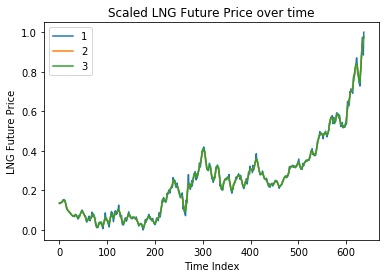

In [9]:
# comparision of the performance of different smoothing parameters
# plt.figure(figsize=(10,10))
plt.plot(range(638),train[target])
plt.plot(savgol_filter(train[target], 5, 1, mode= 'nearest'))
plt.plot(savgol_filter(train[target], 15, 5, mode= 'nearest'))
plt.title('Scaled LNG Future Price over time')
plt.xlabel('Time Index')
plt.ylabel('LNG Future Price')
plt.legend(['1', '2', '3'])
plt.show()

In [10]:
# concat data within a time window - this is based on continues index
def window_features(df, window, k=1):
    for each in numeric_features+[target]:
        df[each] = savgol_filter(df[each], window, k, mode= 'nearest')    
    return df

train = window_features(train, 5)
val = window_features(val, 5)
external_test_new = window_features(external_test, 5)

# LSTM Model

In [11]:
import copy
new_train = copy.copy(train)
new_val = copy.copy(val)
new_test = copy.copy(external_test_new)
train1 = copy.copy(train)
val1 = copy.copy(val)
test1 = copy.copy(external_test_new)

In [12]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
from itertools import product
import os
import random
import re
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
import matplotlib.pyplot as plot
from sklearn.metrics import mean_squared_error as mse

In [13]:
p_t = train['LNG_future']
p_v = val['LNG_future']
p_e = external_test_new['LNG_future']
train = train.drop(['sentiment_mode','sentiment_avg','quantile_75','quantile_25','median'], axis = 1)
val = val.drop(['sentiment_mode','sentiment_avg','quantile_75','quantile_25','median'], axis = 1)
test = external_test_new.drop(['sentiment_mode','sentiment_avg','quantile_75','quantile_25','median'], axis = 1)

In [14]:
train.shape

(638, 23)

In [15]:
# concat data within a time window
# split training and validation set
df = train.drop(['LNG_future'], axis = 1)

def data_form(data, price, window):
    price = price.to_numpy()
    data = data.iloc[:, 1:]
    X, y = [], []  
    for index in range(len(data) - window):   
        X.append(data[index: index + window]) 
        y.append(price[index + window]) 
    X, y = np.array(X), np.array(y).reshape(-1,1)
    x = torch.from_numpy(X).type(torch.Tensor)
    y = torch.from_numpy(y).type(torch.Tensor)
    return [x, y]

all_data_train = data_form(train, p_t, 5)
all_data_val = data_form(val, p_v, 5)
all_data_ex = data_form(external_test, p_e, 5)

In [16]:
## LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

In [17]:
#random seed 
def init_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False       
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

init_random_seed(0)

In [18]:
x_train, y_train= all_data_train[0], all_data_train[1]
x_val, y_val= all_data_val[0], all_data_val[1]
print(x_val.shape)

torch.Size([87, 5, 22])


Training epoch  0 MSE:  0.15363888442516327
Training epoch  20 MSE:  0.013091353699564934
Training epoch  40 MSE:  0.010188719257712364
Training epoch  60 MSE:  0.0067502339370548725
Training epoch  80 MSE:  0.0032724656630307436
train 5 rounds in total, this is the 0 th round, RMSE is0.18694165698252618 

Training epoch  0 MSE:  0.08324164897203445
Training epoch  20 MSE:  0.01377598661929369
Training epoch  40 MSE:  0.008504686877131462
Training epoch  60 MSE:  0.0036540282890200615
Training epoch  80 MSE:  0.0026482255198061466
train 5 rounds in total, this is the 1 th round, RMSE is0.11182457627728581 

Training epoch  0 MSE:  0.21598242223262787
Training epoch  20 MSE:  0.014948789030313492
Training epoch  40 MSE:  0.01137741282582283
Training epoch  60 MSE:  0.008860195986926556
Training epoch  80 MSE:  0.005874179769307375
train 5 rounds in total, this is the 2 th round, RMSE is0.2570429998449981 

Training epoch  0 MSE:  0.1118176132440567
Training epoch  20 MSE:  0.01414989028

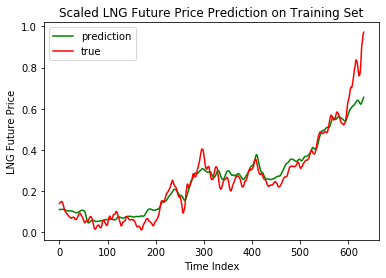

In [19]:
# train
import math
def train(hidden_size, num_epochs, lr, reg, seed=None, plot=True):
    if seed:
        init_random_seed(seed)
    input_dim  = x_train.shape[-1]
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_size, output_dim=1, num_layers=2)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    hist = np.zeros(num_epochs)
    lstm = []
    mse_sum = 0
    for t in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train)
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        if t % 20 == 0:
            print("Training epoch ", t, "MSE: ", loss.item())
            mse_sum += loss.item()
    mse_train = mse_sum        
    y_train_pred = model(x_train)  
    loss = criterion(y_train_pred, y_train).item()
    y_train_pred = y_train_pred.detach().numpy()
    y_train_true = y_train.detach().numpy()
    
    if plot:
        axis = list(range(len(y_train_pred)))
        plt.plot(axis, y_train_pred, c='g', label='prediction')
        plt.plot(axis, y_train_true, c='r', label='true')
        plt.title('Scaled LNG Future Price Prediction on Training Set')
        plt.xlabel('Time Index')
        plt.ylabel('LNG Future Price')
#         plt.xticks(list(range(len(y_train_pred))), ['2020-01-02', '2020-06-03', '2020-10-23', '2021-03-23', '2021-08-13'])
        plt.legend()

    return mse_train, model

# train n times and get the average RMSE
def get_avg_se(run_times, hidden_size, num_epochs, lr, reg):
    train_sum = 0
    for i in range(run_times):
        if i == 0:
            mse_train, model = train(hidden_size, num_epochs, lr, reg, i)
        else:
            mse_train, model = train(hidden_size, num_epochs, lr, reg, i, False)
        print(f'train {run_times} rounds in total, this is the {i} th round, RMSE is{mse_train}', '\n')
    train_sum += math.sqrt(mse_train)
    train_avg = train_sum / run_times
    print(f'average RMSE of training set is {train_avg}')
    return train_avg, model


# train with original features
mse_train, model = get_avg_se(5, 64, 100, 0.01, 0.01)
# torch.save(model.state_dict(), f'/Users/zhang621108/Desktop/LSTM_fulldata.model')



0.15867768


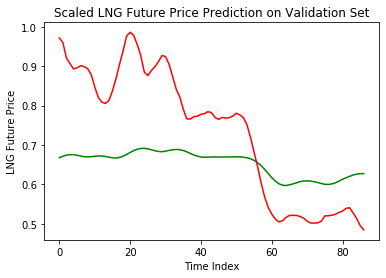

In [20]:
# validation
input_dim  = x_val.shape[-1]


y_val_pred = model(x_val)

y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val.detach().numpy()


RMSE = mse(y_val_true, y_val_pred, squared=False)
print(RMSE)
if plot:
    axis = list(range(len(y_val_pred)))
    plt.plot(axis, y_val_pred, c='g', label='prediction')
    plt.plot(axis, y_val_true, c='r', label='true')
#     plt.ylim(0,1)
#     plt.xticks(list(range(len(y_val_pred))), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
    plt.title('Scaled LNG Future Price Prediction on Validation Set')
    plt.xlabel('Time Index')
    plt.ylabel('LNG Future Price')
    plt.show()

# Model with sentiment analysis

In [21]:
all_data_train = data_form(new_train, p_t, 5)
all_data_val = data_form(new_val, p_v, 5)
all_data_ex = data_form(new_test, p_e, 5)
x_train, y_train= all_data_train[0], all_data_train[1]
x_val, y_val= all_data_val[0], all_data_val[1]
print(x_val.shape)

torch.Size([87, 5, 27])


Training epoch  0 MSE:  0.13354557752609253
Training epoch  20 MSE:  0.013544026762247086
Training epoch  40 MSE:  0.009759189561009407
Training epoch  60 MSE:  0.007348503451794386
Training epoch  80 MSE:  0.003880393924191594
train 5 rounds in total, this is the 0 th round, RMSE is0.168077691225335 

Training epoch  0 MSE:  0.23375298082828522
Training epoch  20 MSE:  0.013093060813844204
Training epoch  40 MSE:  0.010881721042096615
Training epoch  60 MSE:  0.008572990074753761
Training epoch  80 MSE:  0.005891644395887852
train 5 rounds in total, this is the 1 th round, RMSE is0.27219239715486765 

Training epoch  0 MSE:  0.07369869202375412
Training epoch  20 MSE:  0.011937927454710007
Training epoch  40 MSE:  0.00717112235724926
Training epoch  60 MSE:  0.0036569093354046345
Training epoch  80 MSE:  0.0028695224318653345
train 5 rounds in total, this is the 2 th round, RMSE is0.09933417360298336 

Training epoch  0 MSE:  0.07926324754953384
Training epoch  20 MSE:  0.012186883948

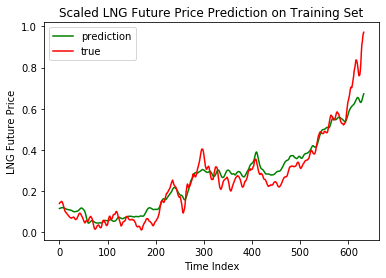

In [22]:
mse_train, model = get_avg_se(5, 64, 100, 0.01, 0.01)

0.15655056


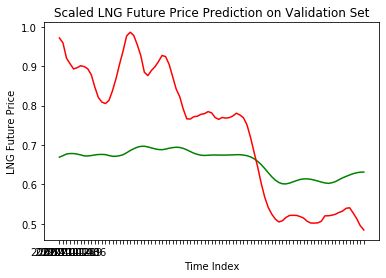

In [23]:
input_dim  = x_val.shape[-1]


y_val_pred = model(x_val)

y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val.detach().numpy()


RMSE = mse(y_val_true, y_val_pred, squared=False)
print(RMSE)
if plot:
    axis = list(range(len(y_val_pred)))
    plt.plot(axis, y_val_pred, c='g', label='prediction')
    plt.plot(axis, y_val_true, c='r', label='true')
#     plt.ylim(0,1)
    plt.xticks(list(range(len(y_val_pred))), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
    plt.title('Scaled LNG Future Price Prediction on Validation Set')
    plt.xlabel('Time Index')
    plt.ylabel('LNG Future Price')
    plt.show()

In [24]:
# x, y= all_data[0], all_data[1]
# print(x.shape)
# y_pred = model(x)
# y_pred = y_pred.tolist()
# d = pd.read_csv('data_with_weekends.csv')
# y_pre = []
# for i in range(len(y_pred)):
#     y_pre.append(y_pred[i][0])
# y_pre.append(0.5897388167381287)
# y_pre.append(0.5853999257087708)
# y_pre.append(0.5786902904510498)
# y_pre.append(0.5700615954399109)
# y_pre.append(0.5886902904510498)
# d['predict_y']= y_pre
# d.to_csv('data_prediction.csv')

# Feature Selection

In [25]:
# selecting feature with three algorithms

def feature_select(data):
    
    X = data.iloc[:, 2:]
    Y = data.iloc[:, 1]
    names = data.columns[2:]
    
    def ridge():
        ridge = Ridge(alpha=5)
        ridge.fit(X, Y)
        scores = [i[0] for i in scaler.fit_transform([[np.abs(i)] for i in ridge.coef_])]
        return scores
    
    def randomForest():
        rf = RandomForestRegressor()
        rf.fit(X, Y)
        scores = scaler.fit_transform(list(map(lambda x: [round(x, 4)], rf.feature_importances_)))
        scores = [i[0] for i in scores]
        return scores
    
    def cov():
        scores = [np.abs(i) for i in data.corr()['LNG_future'][1:]]
        return scores 
    
    crit1, crit2, crit3 = ridge(), randomForest(), cov()
    all_crit = list(zip(names, [(i[0]+i[1]+i[2])/3 for i in list(zip(crit1, crit2, crit3))]))
    return all_crit


all_crit_new = feature_select(new_train)

for i in sorted(all_crit_new, key= lambda x:x[1]):
    print(i)

('quantile_75', 0.027967510696043085)
('quarter', 0.0528729734416686)
('Oil_future_volume', 0.09153474719510281)
('sentiment_avg', 0.09790516764324585)
('LNG_future_volume', 0.10630156285531352)
('Gold_future', 0.1618099419385749)
('VIX', 0.17608536699671054)
('LNG_spot', 0.20399683392555748)
('Dollar_future', 0.22035089937259525)
('DJ_oil_gas_index', 0.24294882698697032)
('year', 0.24476290008331084)
('EEM', 0.25873004180835085)
('DJ_trans', 0.2827139017131608)
('Unemployment', 0.2847826093920422)
('SH', 0.29894163719148376)
('DJI_GI', 0.3039671865228042)
('SPX_GI', 0.3234504856434377)
('DJ_oil_index', 0.3259690898506919)
('XLK', 0.34000932861276006)
('LNG_future', 0.3727050365799733)
('DJC', 0.44196675174761757)
('Oil_spot', 0.7691587060067638)
('DJC_E', 0.8499079954254382)
('sentiment_mode', nan)
('quantile_25', nan)
('median', nan)


Training epoch  0 MSE:  0.1255870908498764
Training epoch  20 MSE:  0.012025950476527214
Training epoch  40 MSE:  0.00943832378834486
Training epoch  60 MSE:  0.007054721470922232
Training epoch  80 MSE:  0.0030244123190641403
train 5 rounds in total, this is the 0 th round, RMSE is0.15713049890473485 

Training epoch  0 MSE:  0.08249454200267792
Training epoch  20 MSE:  0.012312362901866436
Training epoch  40 MSE:  0.008958639577031136
Training epoch  60 MSE:  0.005734182894229889
Training epoch  80 MSE:  0.0027613225392997265
train 5 rounds in total, this is the 1 th round, RMSE is0.1122610499151051 

Training epoch  0 MSE:  0.20677809417247772
Training epoch  20 MSE:  0.014116404578089714
Training epoch  40 MSE:  0.012074039317667484
Training epoch  60 MSE:  0.008523731492459774
Training epoch  80 MSE:  0.005857895594090223
train 5 rounds in total, this is the 2 th round, RMSE is0.24735016515478492 

Training epoch  0 MSE:  0.09915263205766678
Training epoch  20 MSE:  0.012708120048

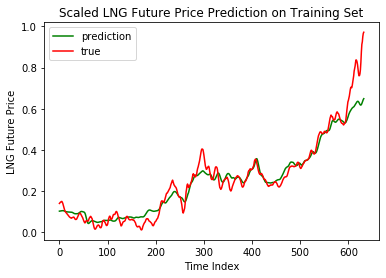

In [26]:
# delete features with low score
features_new = [i[0] for i in all_crit_new if i[0] not in ['Gold_future', 'Oil_future_volume','LNG_future_volume']]
train_reduced = new_train.loc[:, features_new]
all_train_reduced = data_form(train_reduced, p_t, 5)
x_train, y_train= all_train_reduced[0], all_train_reduced[1]
RMSE, model = get_avg_se(5, 64, 100, 0.01, 0.01)

0.15558812


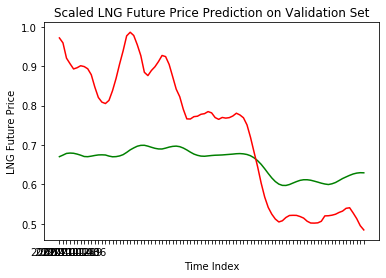

In [27]:
val_reduced = new_val.loc[:, features_new]
all_val_reduced = data_form(val_reduced, p_v, 5)
x_val, y_val= all_val_reduced[0], all_val_reduced[1]
input_dim  = x_val.shape[-1]
y_val_pred = model(x_val)
y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val.detach().numpy()
RMSE = mse(y_val_true, y_val_pred, squared=False)
print(RMSE)
if plot:
    axis = list(range(len(y_val_pred)))
    plt.plot(axis, y_val_pred, c='g', label='prediction')
    plt.plot(axis, y_val_true, c='r', label='true')
#     plt.ylim(0,1)
    plt.xticks(list(range(len(y_val_pred))), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
    plt.title('Scaled LNG Future Price Prediction on Validation Set')
    plt.xlabel('Time Index')
    plt.ylabel('LNG Future Price')
    plt.show()

In [28]:
# # get the data of last 10 days to predict the next day
# print(external_test.iloc[-1, 0])
# latest_x = np.array(external_test_reduced.iloc[:, 1:])
# latest_x = torch.Tensor(latest_x)
# latest_x = latest_x.unsqueeze(0)
# latest_x.shape

In [29]:
# # prediction result
# latest_y = model(latest_x)
# y = latest_y.detach().numpy()
# # latest_y = scaler_price.inverse_transform(latest_y)
# print(f'we predict next day (2022/02/01) LNG future price will be {latest_y}')

# from attention

In [45]:
import numpy as np
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
from attention import Attention
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 

In [46]:
import tensorflow as tf
all_data_train = data_form(train1, p_t, 5)
all_data_val = data_form(val1, p_v, 5)

x_train, y_train = all_data_train
x_val, y_val = all_data_val
train_x = x_train.numpy()
train_y = y_train.numpy()
val_x = x_val.numpy()
val_y = y_val.numpy()


In [47]:
# Dummy data. There is nothing to learn in this example.
time_steps, input_dim, output_dim = 5, 27, 1
# compile the model.
model_input = Input(shape=(time_steps, input_dim))
model = LSTM(256, return_sequences=True)(model_input)
model = Attention(units=256)(model)
model = Dense(4, activation='relu')(model)
model = Dense(output_dim)(model)
model = Model(model_input, model)
model.compile(loss='mae', optimizer='adam')
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 27)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            290816    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               196608    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 488,457
Trainable params: 488,457
Non-trainable params: 0
_________________________________________________________________


In [48]:
# train.
model.fit(train_x, train_y, epochs=30)
# model.save('/Users/zhang621108/Desktop/LSTM_attention_fulldata.modeltest_model.h5')
#model.save('test_model.h5')
#model_h5 = load_model('test_model.h5', custom_objects={'Attention': Attention})
pred_t = model.predict(train_x)
rmse_train = math.sqrt(mean_squared_error(train_y, pred_t))
print(f'average RMSE of training set is {rmse_train}')
pred_v = model.predict(val_x)
rmse_val = math.sqrt(mean_squared_error(val_y, pred_v))
print(f'average RMSE of validation set is {rmse_val}')

Epoch 1/30
20/20 [==============================] - 3s 20ms/step - loss: 0.0836
Epoch 2/30
20/20 [==============================] - 0s 20ms/step - loss: 0.0578
Epoch 3/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0409
Epoch 4/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0294
Epoch 5/30
20/20 [==============================] - 0s 18ms/step - loss: 0.0273
Epoch 6/30
20/20 [==============================] - 0s 18ms/step - loss: 0.0228
Epoch 7/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0220
Epoch 8/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0204
Epoch 9/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0231
Epoch 10/30
20/20 [==============================] - 0s 19ms/step - loss: 0.0232
Epoch 11/30
20/20 [==============================] - 0s 23ms/step - loss: 0.0188
Epoch 12/30
20/20 [==============================] - 0s 21ms/step - loss: 0.0215
Epoch 13/30
20/20 [==================

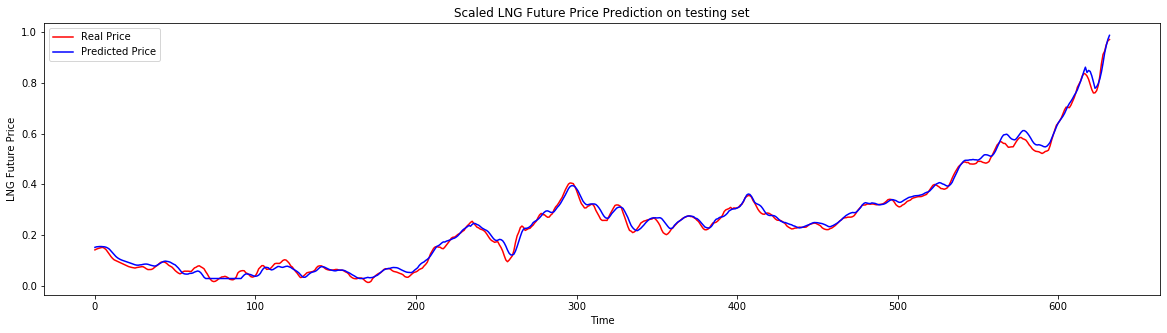

In [49]:
#####plot for testing set
plt.figure(figsize=(20, 5))
plt.plot(train_y, color = 'red', label = 'Real Price')
plt.plot(pred_t, color = 'blue', label = 'Predicted Price')
plt.title('Scaled LNG Future Price Prediction on testing set')
# plt.xticks(list(range(5)), ['2020-01-02', '2020-06-03', '2020-10-23', '2021-03-23', '2021-08-13'])
plt.xlabel('Time')
plt.ylabel('LNG Future Price')
plt.legend()
plt.show()

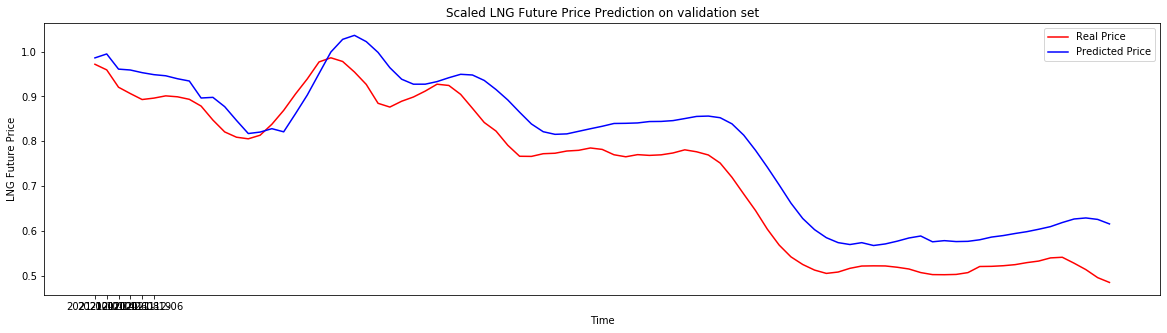

In [50]:
#####plot for validation set
plt.figure(figsize=(20, 5))
plt.plot(val_y, color = 'red', label = 'Real Price')
plt.plot(pred_v, color = 'blue', label = 'Predicted Price')
plt.title('Scaled LNG Future Price Prediction on validation set')
plt.xticks(list(range(6)), ['2021-10-01', '2021-10-14', '2021-10-26', '2021-11-08','2021-11-19', '2021-12-06'])
plt.xlabel('Time')
plt.ylabel('LNG Future Price')
plt.legend()
plt.show()

In [36]:
# # test.
# x_test, y_test = all_data_ex
# test_x = x_test.numpy()
# test_y = y_test.numpy()
# test_pred = model.predict(test_x)
# mean_squared_error(test_y, test_pred)

In [37]:
# #####plot for test set
# plt.figure(figsize=(20, 5))
# plt.plot(test_y, color = 'red', label = 'Real Price')
# plt.plot(test_pred, color = 'blue', label = 'Predicted Price')
# plt.title('Scaled LNG Future Price Prediction on testing set')
# plt.ylim(0,1)
# plt.xlabel('Time')
# plt.ylabel('LNG Future Price')
# plt.legend()latest_x, a= all_data_ex
latest_x.shape
latest = latest_x.numpy()

latest_x.shape

# prediction result
for i in range(26):
    x = torch.unsqueeze(latest_x[i], 0)
    latest = x.numpy()
    latest_y = model(latest)
    print(f'we predict next day 2022-01-{i+6} LNG future price will be {latest_y[0][0]}')

# plt.show()

In [38]:
latest_x, a= all_data_ex
latest_x.shape
latest = latest_x.numpy()

In [39]:
latest_x.shape

torch.Size([26, 5, 27])

In [44]:
# prediction result
for i in range(26):
    x = torch.unsqueeze(latest_x[i], 0)
    latest = x.numpy()
    latest_y = model(latest)
    print(f'we predict next day 2022-01-{i+6} LNG future price will be {latest_y[0][0]}')


we predict next day 2022-01-6 LNG future price will be 0.6379058957099915
we predict next day 2022-01-7 LNG future price will be 0.6465412974357605
we predict next day 2022-01-8 LNG future price will be 0.6561775207519531
we predict next day 2022-01-9 LNG future price will be 0.6622375845909119
we predict next day 2022-01-10 LNG future price will be 0.6573082804679871
we predict next day 2022-01-11 LNG future price will be 0.6616851091384888
we predict next day 2022-01-12 LNG future price will be 0.6844135522842407
we predict next day 2022-01-13 LNG future price will be 0.6871157884597778
we predict next day 2022-01-14 LNG future price will be 0.6889506578445435
we predict next day 2022-01-15 LNG future price will be 0.693557620048523
we predict next day 2022-01-16 LNG future price will be 0.6872535347938538
we predict next day 2022-01-17 LNG future price will be 0.6794334650039673
we predict next day 2022-01-18 LNG future price will be 0.6762998700141907
we predict next day 2022-01-19